In [1]:
# tests for quality of reconstruction and conditioning -- pentapep AA

import numpy as np
import mdshare 
import mdtraj as md
import glob
import pyemma as py
import matplotlib.pyplot as plt

# train tica using pyemma
from pyemma.coordinates import tica
from scipy.spatial.distance import pdist

import matplotlib.pyplot as plt
from scipy.stats import pearsonr, ks_2samp

import pickle as pkl

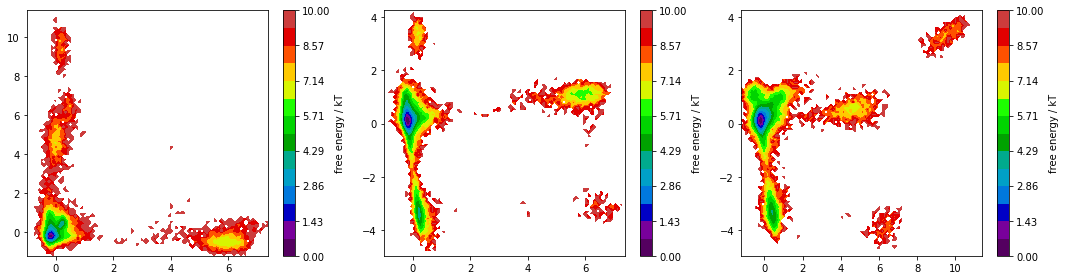

In [11]:
n_srvs = 4
n_atoms = 94

train_name = 'train_pep_AA-heavy'
test_name = 'test_pep_AA-heavy'

# load in original training
pdb = mdshare.fetch('pentapeptide-impl-solv.pdb', working_directory='data_mdshare')
files = mdshare.fetch('pentapeptide-*-500ns-impl-solv.xtc', working_directory='data_mdshare')

trj = md.load(files, top=pdb)
trjs = [md.load(file, top=pdb) for file in files]

# load both in trajs
if 'heavy' in train_name:
    heavy_idxs = trj.top.select_atom_indices('heavy')
else:
    heavy_idxs = trj.top.select('backbone')

heavy_trj = trj.atom_slice(heavy_idxs)
heavy_trj = heavy_trj.superpose(heavy_trj)
heavy_trjs = [t.atom_slice(heavy_idxs) for t in trjs]

# load test samples
test_r = np.load(f'./traj_AIB9/{test_name}_traj.npy')
test_r = test_r[:, n_srvs:].reshape((-1, n_atoms, 3))

# load using heavy trj top
trj_aa_r = md.Trajectory(test_r, topology=trj.top)
trj_r = trj_aa_r.atom_slice(heavy_idxs)
    
# for train tica
pdists = [np.concatenate([pdist(xyz)[None] for xyz in trj.xyz]) for trj in heavy_trjs]

# laod tica
TICA = pkl.load(open(f'./traj_AIB9/tica_pep_AA-heavy.pkl', 'rb'))

projected_data = np.array(TICA.transform(pdists))
projected_data_cat = projected_data.reshape(-1, projected_data.shape[-1])
projected_data_cat.shape

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax = ax.flatten()
py.plots.plot_free_energy(projected_data_cat[:,0], projected_data_cat[:,1], levels=np.linspace(0, 10, 15), ax=ax[0])
py.plots.plot_free_energy(projected_data_cat[:,0], projected_data_cat[:,2], levels=np.linspace(0, 10, 15), ax=ax[1])
py.plots.plot_free_energy(projected_data_cat[:,1], projected_data_cat[:,2], levels=np.linspace(0, 10, 15), ax=ax[2])
plt.tight_layout()

# transform test into tica
pdists_test = [np.concatenate([pdist(xyz)[None] for xyz in trj.xyz]) for trj in trj_r]
tics_r = np.concatenate(TICA.transform(pdists_test))

1 ['./results/train_pep_AA-heavy/32-1-2-4-8-b128/AA-heavy_Unet1D_2000000s/samples_model-35.npy']
(25005, 94, 3) (25005, 44, 3)
(25005, 94, 3) (25005, 44, 3)
(4, 25005) (4, 25005)
AUCs 0.961 0.648
RMSDs 0.184 0.201 0.00639 0.01013
AUCs 0.961 0.648
TICS 0.976825




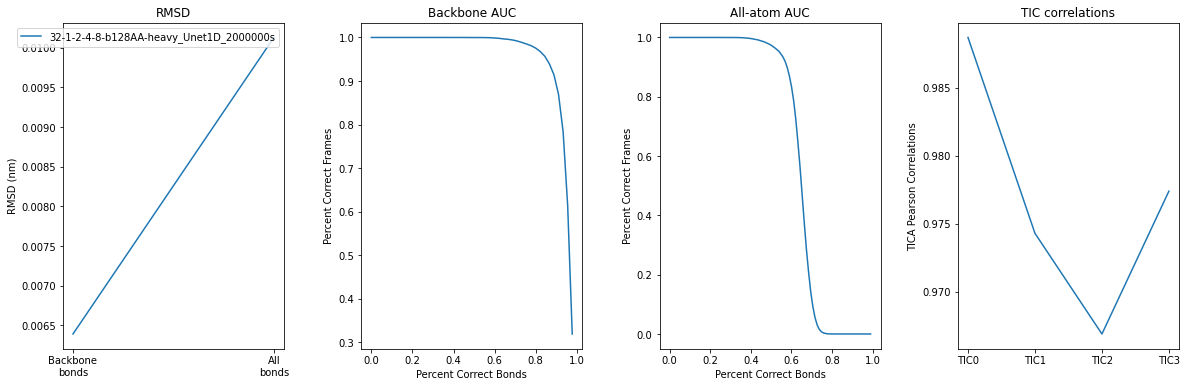

In [12]:
# load using heavy trj top

# for AA hyper param comparisons
lp = f'./results/{train_name}/*4-8*/*Unet1D**2000000s/samples_model*.npy'

#lp = f'./results/{train_name}/*/*Unet*200000s*/samples_final.npy'
synth_names = sorted(glob.glob(f'{lp}'))

print(len(synth_names), synth_names)

# plot rmsd, bonds, and tic correlations on distinct axes
fig, axes = plt.subplots(1, 4, figsize=(20, 6))

for synth_name in synth_names:

    # load synthetics
    test_s = np.load(synth_name)
    test_s = np.squeeze(test_s)[:, n_srvs:].reshape((-1, n_atoms, 3))

    # load full and heavy rjas
    trj_aa_s = md.Trajectory(test_s, topology=trj.top)
    trj_s = trj_aa_s.atom_slice(heavy_idxs)
    
    # save traj
    pkl.dump(trj_aa_s, open('./test_trajs/pep-aa.pkl', 'wb'))

    # synthetic tics
    tics_s = TICA.transform(np.array([pdist(xyz) for xyz in trj_s.xyz]))
    
    print(trj_aa_s.xyz.shape, trj_s.xyz.shape)
    print(trj_aa_r.xyz.shape, trj_r.xyz.shape)
    print(tics_r.T.shape, tics_s.T.shape)

    # tic pearsons
    tic_pears = []
    for t_r, t_s in zip(tics_r.T, tics_s.T):
        p, _ = pearsonr(t_r, t_s)
        tic_pears.append(np.round(p, 4))
        
    # average rmsds 
    rmsd_bb = np.sqrt(np.mean((trj_s.xyz - trj_r.xyz)**2)).round(3)
    rmsd_aa = np.sqrt(np.mean((trj_aa_s.xyz - trj_aa_r.xyz)**2)).round(3)
    
    # all backbone bones
    all_bonds_bb = [(b[0].index, b[1].index) for b in trj_r.top.bonds]  #if 'C' in b[0].element]
    bond_dists_r = md.compute_distances(trj_r, all_bonds_bb)
    bond_dists_s = md.compute_distances(trj_s, all_bonds_bb)
    rmsd_bb_bonds = np.sqrt(np.mean((bond_dists_s -bond_dists_r)**2)).round(5)
    
    # all-atom bonds
    all_bonds_aa = [(b[0].index, b[1].index) for b in trj_aa_r.top.bonds] #if 'hydrogen' in b[1].element]
    bond_aa_dists_r = md.compute_distances(trj_aa_r, all_bonds_aa)
    bond_aa_dists_s = md.compute_distances(trj_aa_s, all_bonds_aa)
    rmsd_aa_bonds = np.sqrt(np.mean((bond_aa_dists_s - bond_aa_dists_r)**2)).round(5)
    
    # what percent of configurations have all correct bonds
    min_bb_r, max_bb_r = np.min(bond_dists_r, axis=0), np.max(bond_dists_r, axis=0)
    correct_bb = np.sum((bond_dists_s < max_bb_r) & (bond_dists_s > min_bb_r),  axis=1) 
    p100_bb = 100*np.sum(correct_bb == len(all_bonds_bb)) / len(correct_bb)
    p80_bb = 100*np.sum(correct_bb > 0.80*len(all_bonds_bb)) / len(correct_bb)
    
    # what percent of AA configurations have all correct bonds
    min_aa_r, max_aa_r = np.min(bond_aa_dists_r, axis=0), np.max(bond_aa_dists_r, axis=0)
    correct_aa = np.sum((bond_aa_dists_s < max_aa_r) & (bond_aa_dists_s > min_aa_r),  axis=1) 
    p60_aa = 100*np.sum(correct_aa > 0.60*len(all_bonds_aa)) / len(correct_aa)
    p40_aa = 100*np.sum(correct_aa > 0.40*len(all_bonds_aa)) / len(correct_aa)
    
    # AUC bb
    min_bb_r, max_bb_r = np.min(bond_dists_r, axis=0), np.max(bond_dists_r, axis=0)
    correct_bb = np.sum((bond_dists_s < max_bb_r) & (bond_dists_s > min_bb_r),  axis=1) 
    auc_bb = []
    for i in range(len(all_bonds_bb)):
        auc = np.sum(correct_bb > i) / len(correct_bb)
        auc_bb.append(auc)
        
    # AUC aa
    min_aa_r, max_baa_r = np.min(bond_aa_dists_r, axis=0), np.max(bond_aa_dists_r, axis=0)
    correct_aa = np.sum((bond_aa_dists_s < max_aa_r) & (bond_aa_dists_s > min_aa_r),  axis=1) 
    auc_aa = []
    for i in range(len(all_bonds_aa)):
        auc = np.sum(correct_aa > i) / len(correct_aa)
        auc_aa.append(auc)
    
    label = synth_name.split('/')[-3] +  synth_name.split('/')[-2]  #synth_name.split('/')[-1].replace('.npy', '').replace('samples', '')
    
    axes[0].plot([0, 1], [rmsd_bb_bonds, rmsd_aa_bonds], label=label)
    axes[0].set_ylabel('RMSD (nm)')
    axes[0].set_xticks(np.arange(2))
    axes[0].set_xticklabels(['Backbone\nbonds', 'All\nbonds'])
    axes[0].set_title('RMSD')
    
    print('AUCs', (np.sum(auc_bb)/len(all_bonds_bb)).round(3), (np.sum(auc_aa)/len(all_bonds_aa)).round(3))
    
    axes[1].plot(np.arange(len(all_bonds_bb))/len(all_bonds_bb), auc_bb)
    axes[1].set_ylabel('Percent Correct Frames')
    axes[1].set_xlabel('Percent Correct Bonds')
    axes[1].set_title('Backbone AUC')
    
    axes[2].plot(np.arange(len(all_bonds_aa))/len(all_bonds_aa), auc_aa)
    axes[2].set_ylabel('Percent Correct Frames')
    axes[2].set_xlabel('Percent Correct Bonds')
    axes[2].set_title('All-atom AUC')

    axes[3].plot(tic_pears)
    axes[3].set_ylabel('TICA Pearson Correlations')
    axes[3].set_xticks(np.arange(4))
    axes[3].set_xticklabels(['TIC0', 'TIC1', 'TIC2', 'TIC3'])
    axes[3].set_title('TIC correlations')
    
    #rmsd_aa = np.sqrt(np.mean((trj_aa_s.xyz - trj_aa_r.xyz)**2)).round(3)
        
    print('RMSDs', rmsd_bb, rmsd_aa, rmsd_bb_bonds, rmsd_aa_bonds)
    
    print('AUCs', (np.sum(auc_bb)/len(all_bonds_bb)).round(3), (np.sum(auc_aa)/len(all_bonds_aa)).round(3))
    
    print('TICS', np.mean(tic_pears))
    
    print('\n')
    
    #axes[0].bar(tic_pears)
        
plt.subplots_adjust(wspace=0.35)
axes[0].legend(loc='upper right')

/project/andrewferguson/Mike/conda_envs/diffusion_env/lib/python3.7/site-packages/pyemma/plots/plots2d.py:253: UserWarning: bins=25 is not an allowed optional parameter and will be ignored
  ' be ignored'.format(key, kwargs[key]))


(-1.0139386880397796, 6.851289294958114) (-1.2197564440965651, 10.589335401654242)


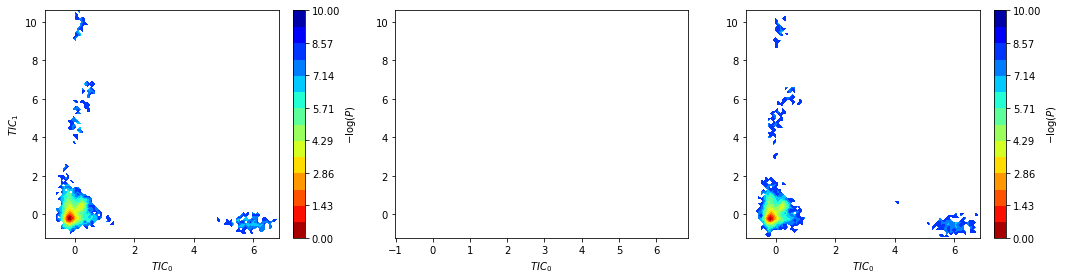

In [4]:
# plot real vs. synthetic tics

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax = ax.flatten()

py.plots.plot_free_energy(tics_r[:, 0], tics_r[:, 1], levels=np.linspace(0, 10, 15), 
                          bins=25, ax=ax[0], cbar_label=r'$-\log(P)$', cmap='jet_r')
py.plots.plot_free_energy(tics_s[:, 0], tics_s[:, 1],  levels=np.linspace(0, 10, 15), 
                          bins=25, ax=ax[2], cbar_label=r'$-\log(P)$', cmap='jet_r')

x_lim = ax[0].get_xlim()
y_lim = ax[0].get_ylim()

print(x_lim, y_lim)

ax[0].set_ylabel(r'$TIC_1$')
for a in ax:
    a.set_xlabel(r'$TIC_0$')
    a.set_xlim(*x_lim)
    a.set_ylim(*y_lim)

plt.tight_layout()

RMSDs 0.07967 0.00629
AUCs 0.964
TICS 0.9789




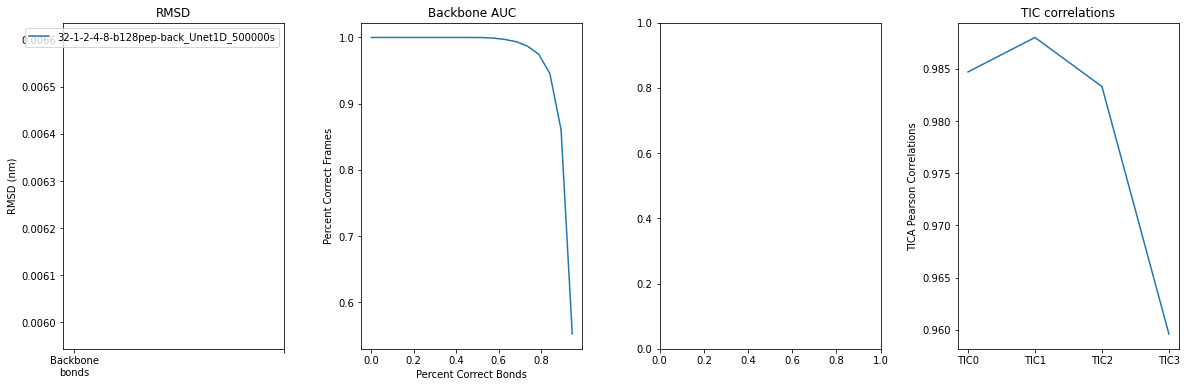

In [10]:
# For train_pep look only at backbone parameters

n_srvs = 4
n_atoms = 20 #94

train_name = 'train_pep' #'train_pep_AA-heavy'
test_name = 'test_pep'    #'test_pep_AA-heavy'

# for backbone comparisons
lp = f'./results/{train_name}/*/*Unet*00000s/samples_final*.npy'
synth_names = sorted(glob.glob(f'{lp}'))

# plot rmsd, bonds, and tic correlations on distinct axes
fig, axes = plt.subplots(1, 4, figsize=(20, 6))

# load in original training
pdb = mdshare.fetch('pentapeptide-impl-solv.pdb', working_directory='data_mdshare')
files = mdshare.fetch('pentapeptide-*-500ns-impl-solv.xtc', working_directory='data_mdshare')

trj = md.load(files, top=pdb)
trjs = [md.load(file, top=pdb) for file in files]

heavy_idxs = trj.top.select('backbone')
heavy_trj = trj.atom_slice(heavy_idxs)
heavy_trj = heavy_trj.superpose(heavy_trj)
heavy_trjs = [t.atom_slice(heavy_idxs) for t in trjs]

# load test samples
test_r = np.load(f'./traj_AIB9/{test_name}_traj.npy')
test_r = test_r[:, n_srvs:].reshape((-1, n_atoms, 3))
trj_r = md.Trajectory(test_r, topology=heavy_trj.top)

# load tica
TICA = pkl.load(open(f'./traj_AIB9/tica_pep_backbone.pkl', 'rb'))

# transform test into tica
pdists_test = [np.concatenate([pdist(xyz)[None] for xyz in trj.xyz]) for trj in trj_r]
tics_r = np.concatenate(TICA.transform(pdists_test))


for synth_name in synth_names:

    # load synthetics
    test_s = np.load(synth_name)
    test_s = np.squeeze(test_s)[:, n_srvs:].reshape((-1, n_atoms, 3))

    # load full and heavy rjas
    trj_s = md.Trajectory(test_s, topology=heavy_trj.top)
    
    # save trajs
    pkl.dump(trj_s, open('./test_trajs/pep-bb.pkl', 'wb'))

    # synthetic tics
    tics_s = TICA.transform(np.array([pdist(xyz) for xyz in trj_s.xyz]))

    # tic pearsons
    tic_pears = []
    for t_r, t_s in zip(tics_r.T, tics_s.T):
        p, _ = pearsonr(t_r, t_s)
        tic_pears.append(np.round(p, 4))
        
    # average rmsds 
    rmsd_bb = np.sqrt(np.mean((trj_s.xyz - trj_r.xyz)**2)).round(5)
    
    # all backbone bones
    all_bonds_bb = [(b[0].index, b[1].index) for b in trj_r.top.bonds]  #if 'C' in b[0].element]
    bond_dists_r = md.compute_distances(trj_r, all_bonds_bb)
    bond_dists_s = md.compute_distances(trj_s, all_bonds_bb)
    rmsd_bb_bonds = np.sqrt(np.mean((bond_dists_s -bond_dists_r)**2)).round(5)

    # what percent of configurations have all correct bonds
    min_bb_r, max_bb_r = np.min(bond_dists_r, axis=0), np.max(bond_dists_r, axis=0)
    correct_bb = np.sum((bond_dists_s < max_bb_r) & (bond_dists_s > min_bb_r),  axis=1) 
    p100_bb = 100*np.sum(correct_bb == len(all_bonds_bb)) / len(correct_bb)
    p80_bb = 100*np.sum(correct_bb > 0.80*len(all_bonds_bb)) / len(correct_bb)
    
    # AUC bb
    min_bb_r, max_bb_r = np.min(bond_dists_r, axis=0), np.max(bond_dists_r, axis=0)
    correct_bb = np.sum((bond_dists_s < max_bb_r) & (bond_dists_s > min_bb_r),  axis=1) 
    auc_bb = []
    for i in range(len(all_bonds_bb)):
        auc = np.sum(correct_bb > i) / len(correct_bb)
        auc_bb.append(auc)
    
    label = synth_name.split('/')[-3] +  synth_name.split('/')[-2]  #synth_name.split('/')[-1].replace('.npy', '').replace('samples', '')
    
    axes[0].plot([0], [rmsd_bb_bonds], label=label)
    axes[0].set_ylabel('RMSD (nm)')
    axes[0].set_xticks(np.arange(2))
    axes[0].set_xticklabels(['Backbone\nbonds'])
    axes[0].set_title('RMSD')
    
    axes[1].plot(np.arange(len(all_bonds_bb))/len(all_bonds_bb), auc_bb)
    axes[1].set_ylabel('Percent Correct Frames')
    axes[1].set_xlabel('Percent Correct Bonds')
    axes[1].set_title('Backbone AUC')
    
    axes[3].plot(tic_pears)
    axes[3].set_ylabel('TICA Pearson Correlations')
    axes[3].set_xticks(np.arange(4))
    axes[3].set_xticklabels(['TIC0', 'TIC1', 'TIC2', 'TIC3'])
    axes[3].set_title('TIC correlations')
    
    #rmsd_aa = np.sqrt(np.mean((trj_aa_s.xyz - trj_aa_r.xyz)**2)).round(3)
        
    print('RMSDs', rmsd_bb, rmsd_bb_bonds)
    
    print('AUCs', (np.sum(auc_bb)/len(all_bonds_bb)).round(3))
    
    print('TICS', np.mean(tic_pears))
    
    print('\n')
    
    #axes[0].bar(tic_pears)

        
plt.subplots_adjust(wspace=0.35)
axes[0].legend(loc='upper right')


(-2.012047280073166, 6.518851507902146) (-1.5696704304218292, 5.02437686085701)


/project/andrewferguson/Mike/conda_envs/diffusion_env/lib/python3.7/site-packages/pyemma/plots/plots2d.py:253: UserWarning: bins=25 is not an allowed optional parameter and will be ignored
  ' be ignored'.format(key, kwargs[key]))


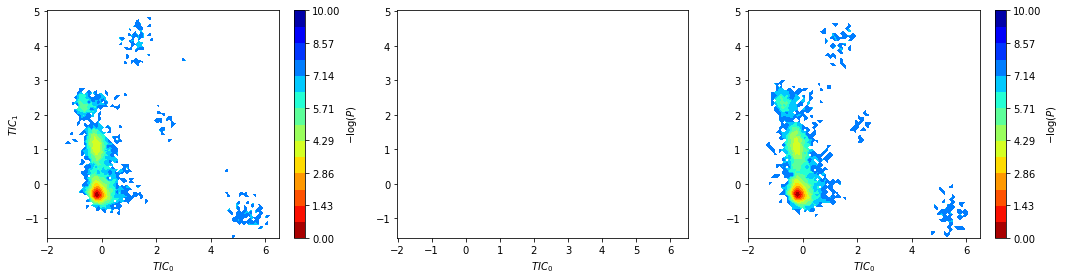

In [22]:
# plot real vs. synthetic tics

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax = ax.flatten()

py.plots.plot_free_energy(tics_r[:, 0], tics_r[:, 1], levels=np.linspace(0, 10, 15), 
                          bins=25, ax=ax[0], cbar_label=r'$-\log(P)$', cmap='jet_r')
py.plots.plot_free_energy(tics_s[:, 0], tics_s[:, 1],  levels=np.linspace(0, 10, 15), 
                          bins=25, ax=ax[2], cbar_label=r'$-\log(P)$', cmap='jet_r')

x_lim = ax[0].get_xlim()
y_lim = ax[0].get_ylim()

print(x_lim, y_lim)

ax[0].set_ylabel(r'$TIC_1$')
for a in ax:
    a.set_xlabel(r'$TIC_0$')
    a.set_xlim(*x_lim)
    a.set_ylim(*y_lim)

plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)
ax = ax.flatten()

#py.plots.plot_free_energy(tics_r[:, 0], tics_r[:, 1], levels=np.linspace(0, 10, 15), bins=25, ax=ax[0])
#py.plots.plot_free_energy(tics_s[:, 0], tics_s[:, 1], levels=np.linspace(0, 10, 15), bins=25, ax=ax[1])

py.plots.plot_density(tics_r[:, 0], tics_r[:, 1], bins=25, ax=ax[0])
py.plots.plot_density(tics_s[:, 0], tics_s[:, 1], bins=25, ax=ax[1])

#py.plots.plot_free_energy(projected_data_cat[:,1], projected_data_cat[:,2], levels=np.linspace(0, 10, 15), ax=ax[2])
plt.tight_layout()

(250000, 2)
RMSDs 0.01082 0.00377
AUCs 0.999842
0.984575
TICS None


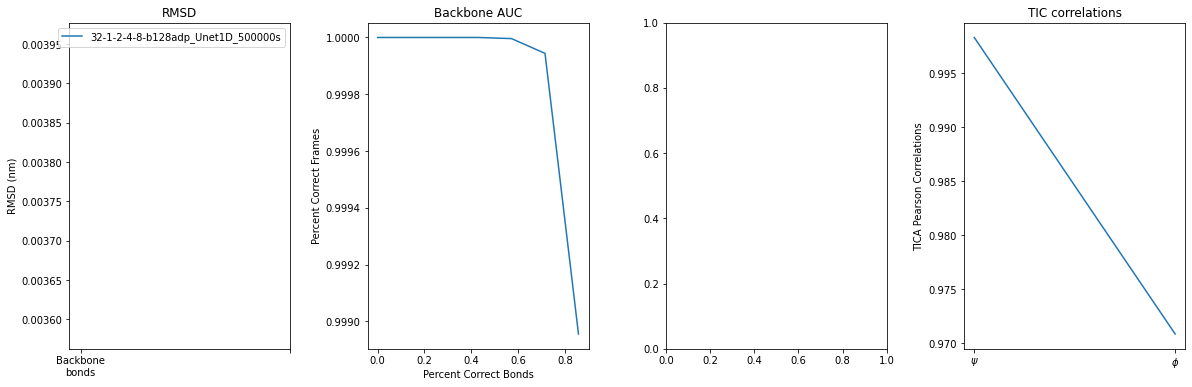

In [13]:
# For train_pep look only at backbone parameters

n_srvs = 2
n_atoms = 8 #94

train_name = 'train_adp' #'train_pep_AA-heavy'
test_name = 'test_adp'    #'test_pep_AA-heavy'

# for backbone comparisons
lp = f'./results/{train_name}/*/*Unet*00000s/samples_final*.npy'
synth_names = sorted(glob.glob(f'{lp}'))

# plot rmsd, bonds, and tic correlations on distinct axes
fig, axes = plt.subplots(1, 4, figsize=(20, 6))

# load in original training
pdb = mdshare.fetch('alanine-dipeptide-nowater.pdb', working_directory='data')
files = mdshare.fetch('alanine-dipeptide-*-250ns-nowater.xtc', working_directory='data')

trj = md.load(files, top=pdb)
trjs = [md.load(file, top=pdb) for file in files]

heavy_idxs = trj.top.select('backbone')
heavy_trj = trj.atom_slice(heavy_idxs)

test_r = np.load(f'./traj_AIB9/{test_name}_traj.npy')
test_r = test_r[:, n_srvs:].reshape((-1, n_atoms, 3))
trj_r = md.Trajectory(test_r, topology=heavy_trj.top)

# use dihedrals for conditioning
tics_r = np.array([md.compute_phi(trj_r)[1], md.compute_psi(trj_r)[1]])[...,0].T

print(tics_r.shape)

for synth_name in synth_names:

    # load synthetics
    test_s = np.load(synth_name)
    test_s = np.squeeze(test_s)[:, n_srvs:].reshape((-1, n_atoms, 3))

    # load full and heavy rjas
    trj_s = md.Trajectory(test_s, topology=heavy_trj.top)
    
    # save trajs
    pkl.dump(trj_s, open('./test_trajs/adp.pkl', 'wb'))

    # synthetic tics
    tics_s = np.array([md.compute_phi(trj_s)[1], md.compute_psi(trj_s)[1]])[...,0].T

    # tic pearsons
    tic_pears = []
    for t_r, t_s in zip(tics_r.T, tics_s.T):
        p, _ = pearsonr(t_r, t_s)
        tic_pears.append(np.round(p, 5))
        
    # average rmsds 
    rmsd_bb = np.sqrt(np.mean((trj_s.xyz - trj_r.xyz)**2)).round(5)
    
    # all backbone bones
    all_bonds_bb = [(b[0].index, b[1].index) for b in trj_r.top.bonds]  #if 'C' in b[0].element]
    bond_dists_r = md.compute_distances(trj_r, all_bonds_bb)
    bond_dists_s = md.compute_distances(trj_s, all_bonds_bb)
    rmsd_bb_bonds = np.sqrt(np.mean((bond_dists_s -bond_dists_r)**2)).round(5)

    # what percent of configurations have all correct bonds
    min_bb_r, max_bb_r = np.min(bond_dists_r, axis=0), np.max(bond_dists_r, axis=0)
    correct_bb = np.sum((bond_dists_s < max_bb_r) & (bond_dists_s > min_bb_r),  axis=1) 
    p100_bb = 100*np.sum(correct_bb == len(all_bonds_bb)) / len(correct_bb)
    p80_bb = 100*np.sum(correct_bb > 0.80*len(all_bonds_bb)) / len(correct_bb)
    
    # AUC bb
    min_bb_r, max_bb_r = np.min(bond_dists_r, axis=0), np.max(bond_dists_r, axis=0)
    correct_bb = np.sum((bond_dists_s < max_bb_r) & (bond_dists_s > min_bb_r),  axis=1) 
    auc_bb = []
    for i in range(len(all_bonds_bb)):
        auc = np.sum(correct_bb > i) / len(correct_bb)
        auc_bb.append(auc)
    
    label = synth_name.split('/')[-3] +  synth_name.split('/')[-2]  #synth_name.split('/')[-1].replace('.npy', '').replace('samples', '')
    
    axes[0].plot([0], [rmsd_bb_bonds], label=label)
    axes[0].set_ylabel('RMSD (nm)')
    axes[0].set_xticks(np.arange(2))
    axes[0].set_xticklabels(['Backbone\nbonds'])
    axes[0].set_title('RMSD')
    
    axes[1].plot(np.arange(len(all_bonds_bb))/len(all_bonds_bb), auc_bb)
    axes[1].set_ylabel('Percent Correct Frames')
    axes[1].set_xlabel('Percent Correct Bonds')
    axes[1].set_title('Backbone AUC')
    
    axes[3].plot(tic_pears)
    axes[3].set_ylabel('TICA Pearson Correlations')
    axes[3].set_xticks(np.arange(2))
    axes[3].set_xticklabels([r'$\psi$', r'$\phi$'])
    axes[3].set_title('TIC correlations')
    
    #rmsd_aa = np.sqrt(np.mean((trj_aa_s.xyz - trj_aa_r.xyz)**2)).round(3)
        
    print('RMSDs', rmsd_bb, rmsd_bb_bonds)
    
    print('AUCs', (np.sum(auc_bb)/len(all_bonds_bb)).round(6))
    
    print('TICS', print(np.mean(tic_pears)))
    
    
    #axes[0].bar(tic_pears)
        
plt.subplots_adjust(wspace=0.35)
axes[0].legend(loc='upper right')

/project/andrewferguson/Mike/conda_envs/diffusion_env/lib/python3.7/site-packages/pyemma/plots/plots2d.py:253: UserWarning: bins=25 is not an allowed optional parameter and will be ignored
  ' be ignored'.format(key, kwargs[key]))


(-3.105526202917099, 3.1099686563014983) (-3.110161417722702, 3.1101721465587615)


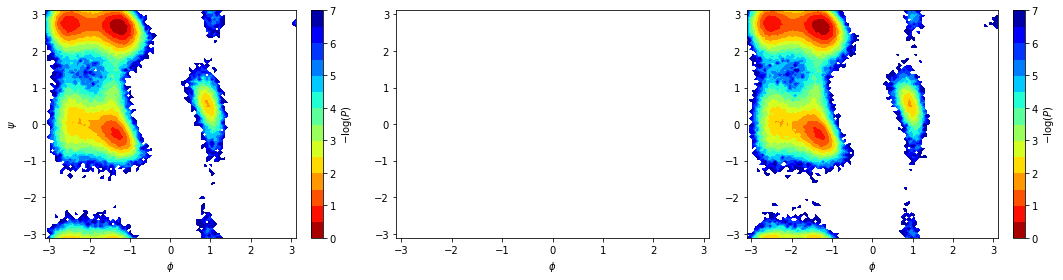

In [26]:
# plot real vs. synthetic tics

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax = ax.flatten()

py.plots.plot_free_energy(tics_r[:, 0], tics_r[:, 1], levels=np.linspace(0, 7, 15), 
                          bins=25, ax=ax[0], cbar_label=r'$-\log(P)$', cmap='jet_r')
py.plots.plot_free_energy(tics_s[:, 0], tics_s[:, 1],  levels=np.linspace(0, 7, 15), 
                          bins=25, ax=ax[2], cbar_label=r'$-\log(P)$', cmap='jet_r')

x_lim = ax[0].get_xlim()
y_lim = ax[0].get_ylim()

print(x_lim, y_lim)

ax[0].set_ylabel(r'$\psi$')
for a in ax:
    a.set_xlabel(r'$\phi$')
    a.set_xlim(*x_lim)
    a.set_ylim(*y_lim)

plt.tight_layout()

In [ ]:
# visualize traj comparisions

In [28]:
# compare reconstructed traj against conditioning

from nglview import NGLWidget

view = NGLWidget() 
view.add_trajectory(trj_r)
view.add_trajectory(trj_s)

op_list = [0.4, 1.0]
for v, op in zip(view, op_list):
    v.clear_representations()
    v.add_representation('ball+stick', opacity=op)
view

NGLWidget(max_frame=249999)

In [20]:
## compare reconstructed traj against conditioning

from nglview import NGLWidget

view = NGLWidget() 
view.add_trajectory(trj_aa_r)
view.add_trajectory(trj_aa_s)

op_list = [0, 1.0]
for v, op in zip(view, op_list):
    v.clear_representations()
    v.add_representation('ball+stick', opacity=op)
view

NGLWidget(max_frame=25004)

In [56]:
# load in models that did not finish running

lp = f'./results/{train_name}/*/*Unet*00000s/'
model_dir = sorted(glob.glob(f'{lp}'))[-1]
last_model = sorted(glob.glob(f'{model_dir}model-??.pt'))[-1]

print(last_model)

./results/train_pep_AA-heavy/32-1-2-4-8-b128/AA-heavy_Unet_2000000s/model-45.pt
